# Electric Vehicle Charging Demand
---
This notebook runs an LCOE-optimized wind/solar/storage plant in Boulder, CO based on a load following schedule representing an hourly EV load demand. The EV demand was generated using EVI-Pro (Lite).

### Import Required Modules
Begin by importing the necessary modules for the simulation.

In [1]:
import calendar

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from hopp import ROOT_DIR
from hopp.simulation import HoppInterface
from hopp.utilities import load_yaml
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from ev.optimization.run_cases import get_best_case
from ev.utils import save_figs

/Users/cirmas/workspace/HOPP/ev/notebooks/log/hybrid_systems_2024-01-24T14.58.49.920653.log


/opt/anaconda3/envs/hopp/lib/python3.8/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


In [2]:
sns.set_theme()

In [3]:
figs = {}
SAVE_FIGS = True

### Set Site Information
Set wind and solar resource data at plant location and load pricing data. In this example, we use the Flatirons site as an example location.

**NOTE**: For a load following objective function the `desired_schedule` must be set.

In [4]:
ev_load = pd.read_csv("../data/boulder_demand_evi.csv", header=None)

In [5]:
dates = pd.date_range(start="2022-01-01", end="2023-01-01", freq="H")

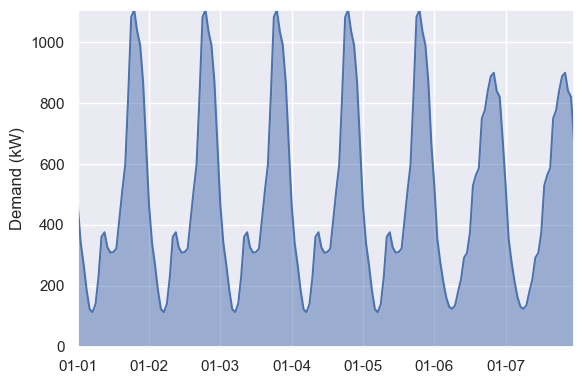

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
periods = 24 * 7
load = ev_load.iloc[:periods, 0]

ax.plot(dates[:periods], load)
ax.fill_between(dates[:periods], 0, load, alpha=0.5)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# ax.set_title("Hourly EV Charging Demand")
ax.set_ylabel("Demand (kW)")

ax.set_xmargin(0)
ax.set_ymargin(0)

fig.tight_layout()
figs["hourly_demand"] = fig

plt.show()

In [7]:
DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
DEFAULT_PRICE_FILE = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"

site = SiteInfo(
        flatirons_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        grid_resource_file=DEFAULT_PRICE_FILE,
        desired_schedule=ev_load.iloc[:, 0].values / 1000, # MW
        solar=True,
        wind=True,
        wave=False
    )

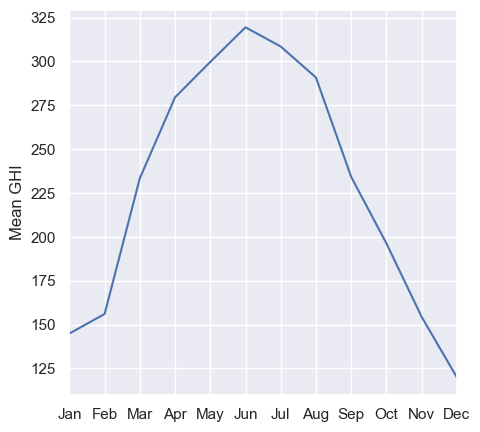

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

df = pd.read_csv(DEFAULT_SOLAR_RESOURCE_FILE, header=2)

dates = pd.date_range(start="2020-01-01", periods=8760, freq="H")
df.index = dates
df["month"] = df.index.month
months = df["month"].apply(lambda x: calendar.month_abbr[x])

y = df["GHI"].groupby(df.index.month).mean()

ax.set_xmargin(0)
ax.plot(months.unique(), y)
# ax.set_title("Solar Resource")
ax.set_ylabel("Mean GHI")

figs["solar_resource"] = fig

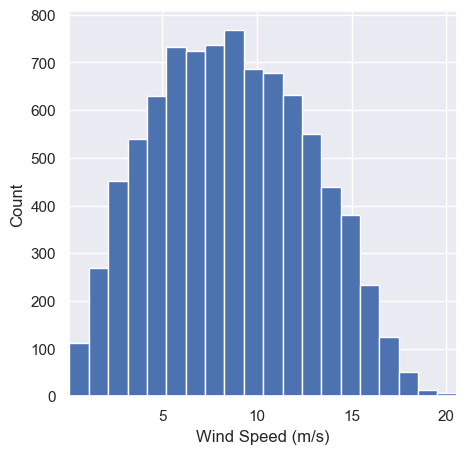

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

df = pd.read_csv(DEFAULT_WIND_RESOURCE_FILE, header=2, skiprows=[3,4])
ws_100m = df["Speed.1"]

ax.set_xmargin(0)
ax.hist(ws_100m, bins=20)
# ax.set_title("Wind Speed Histogram, 100m")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Count")

figs["ws_hist"] = fig

### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration.

`HOPPInterface` is capable of handling dictionary input as well as class instances. Here we demonstrate this by loading the YAML file as a dict, modifying it to include our site information, then passing it as an argument to `HoppInterface`. This is useful for programmatic configuration of simulation configs.

In [10]:
case = get_best_case("sweep_battery_2")

case

{'case': {'battery_capacity_kw': 600,
  'battery_capacity_kwh': 1950.0,
  'threshold_kw': 500,
  'missed_allowed': 30},
 'technologies': {'pv': {'system_capacity_kw': 446.1646675301198},
  'wind': {'turbine_rating_kw': 594.2172364021573},
  'battery': {'system_capacity_kw': 600, 'system_capacity_kwh': 1950.0}},
 'lcoe_real': 0.07988288098634236,
 'avg_missed_peak_load': 29.931143963364093}

In [11]:
hopp_config = load_yaml("../inputs/ev-load-following-battery.yaml")
# set SiteInfo instance
hopp_config["site"] = site

hopp_config["technologies"].update(case["technologies"])
hopp_config["technologies"]["wind"]["num_turbines"] = 1

hopp_config

{'technologies': {'pv': {'system_capacity_kw': 446.1646675301198},
  'wind': {'turbine_rating_kw': 594.2172364021573, 'num_turbines': 1},
  'battery': {'system_capacity_kw': 600, 'system_capacity_kwh': 1950.0},
  'grid': {'interconnect_kw': 10000, 'ppa_price': 0.05}},
 'config': {'dispatch_options': {'battery_dispatch': 'peak_shaving_heuristic',
   'load_threshold_kw': 500}},
 'site': SiteInfo(data={'lat': 35.2018863, 'lon': -101.945027, 'elev': 1099, 'year': 2012, 'tz': -6, 'site_boundaries': {'verts': [[3.0599999999976717, 288.87000000011176], [0.0, 1084.0300000002608], [1784.0499999999884, 1084.2400000002235], [1794.0900000000256, 999.6399999996647], [1494.3400000000256, 950.9699999997392], [712.640000000014, 262.79999999981374], [1216.9800000000396, 272.3600000003353], [1217.7600000000093, 151.62000000011176], [708.140000000014, 0.0]], 'verts_simple': [[3.0599999999976717, 288.87000000011176], [0.0, 1084.0300000002608], [1784.0499999999884, 1084.2400000002235], [1794.0900000000256,

### Create the Simulation Model
Instantiate the `HoppInterface` class by providing our modified configuration dict.

In [12]:
hi = HoppInterface(hopp_config)

### Run the Simulation

In [13]:
hi.simulate()

### Print Simulation Results
Access and display various simulation results, including annual energies, net present values (NPVs), and total revenues.

In [14]:
hybrid_plant = hi.system

# print("Output after losses over gross output:",
      # hybrid_plant.wind.value("annual_energy") / hybrid_plant.wind.value("annual_gross_energy"))

# Save the outputs
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values

print("Annual Energies:")
print(annual_energies)

print("Net Present Values:")
print(npvs)

Annual Energies:
{"pv": 930684.5124924924, "wind": 1946004.717330139, "battery": -8609.79610476488, "hybrid": 1876260.81541537}
Net Present Values:
{"pv": 41951.70561240043, "wind": 181936.87011662242, "battery": -490555.98955558654, "hybrid": -775267.1907302358}


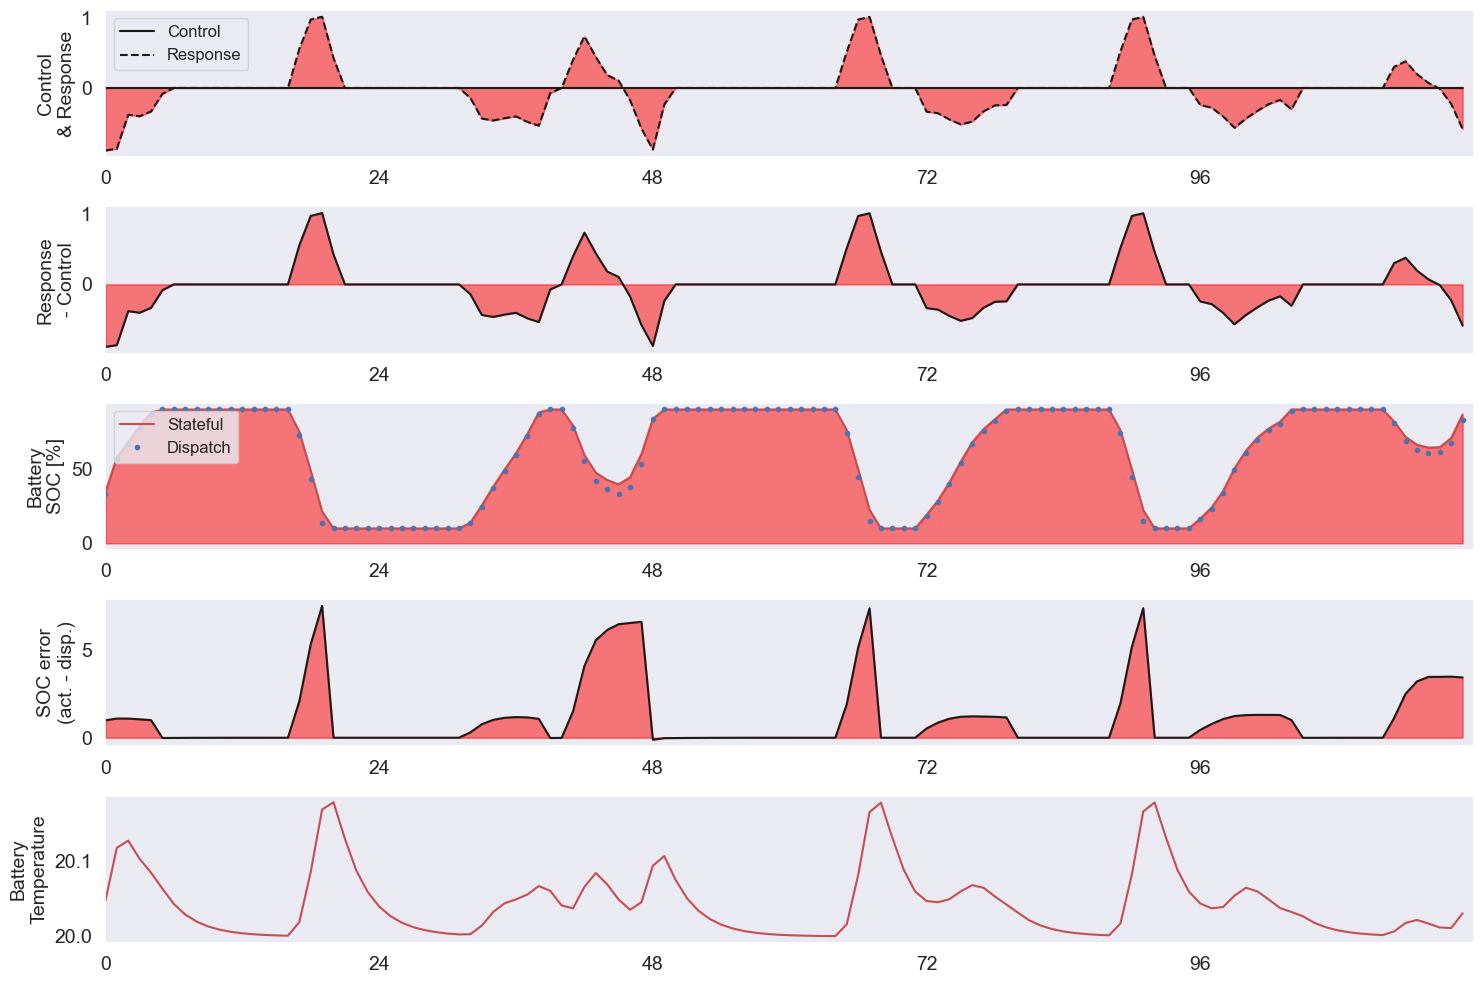

In [15]:
plot_battery_output(hybrid_plant)

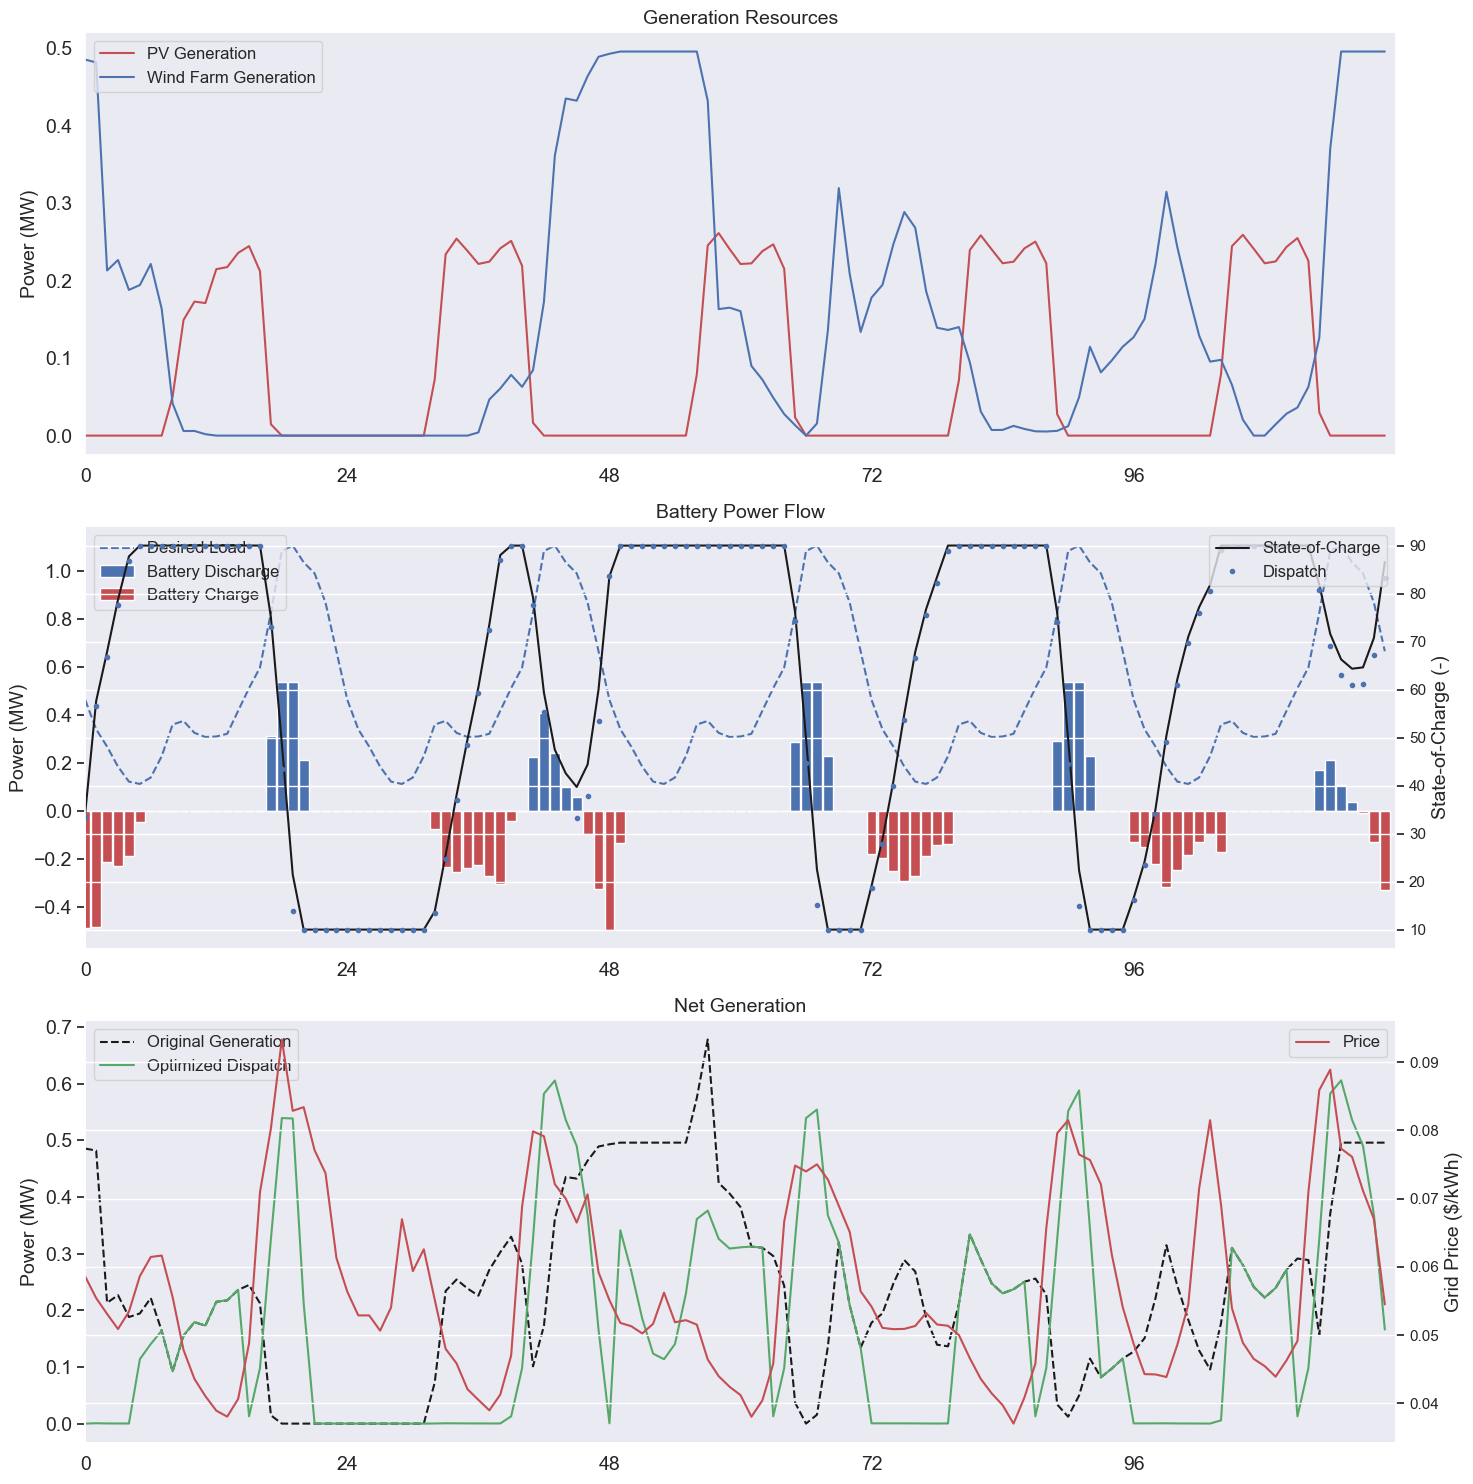

In [16]:
plot_generation_profile(hybrid_plant)

In [17]:
start = 24*7*2
end = 24*7*3

In [18]:
hybrid_plant.lcoe_real["hybrid"]/100

0.07988288098634236

In [19]:
res_df = pd.DataFrame({
    "ev_load": hybrid_plant.site.desired_schedule[:8760] * 1000,
    "hybrid": hybrid_plant.generation_profile["hybrid"][:8760],
    "pv": hybrid_plant.generation_profile["pv"][:8760],
    "wind": hybrid_plant.generation_profile["wind"][:8760],
    "battery": hybrid_plant.generation_profile["battery"][:8760],
    "hour": np.tile(np.arange(24), 365)
})

def calc_shaved(row):
    threshold_kw = case["case"]["threshold_kw"]
    desired = row["ev_load"] - threshold_kw
    
    if row["ev_load"] < threshold_kw:
        return row["ev_load"]
    elif row["hybrid"] < desired:
        return row["ev_load"] - row["hybrid"]
    else:
        return threshold_kw

res_df["y_peak_shaved"] = res_df.apply(calc_shaved, axis=1)

In [32]:
hybrid_plant.grid.missed_load_percentage

0.14934070689233966

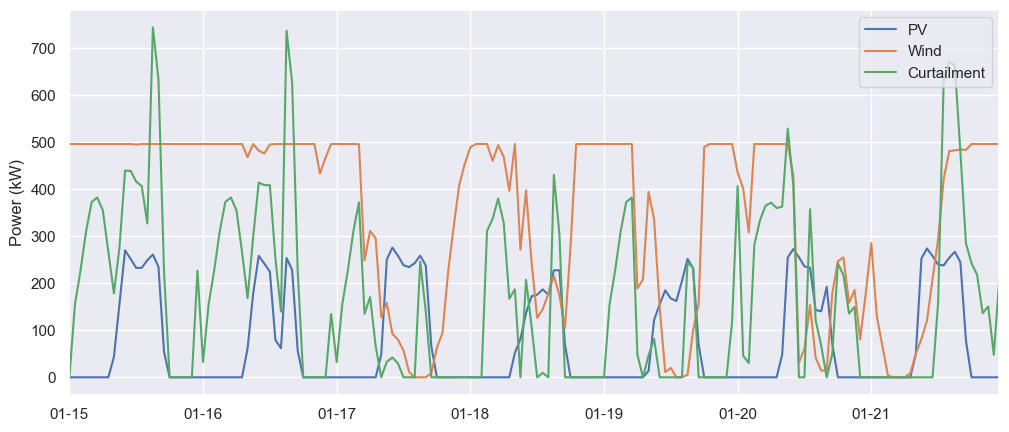

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax.plot(dates[start:end], res_df["pv"][start:end], label="PV")
ax.plot(dates[start:end], res_df["wind"][start:end], label="Wind")
# ax.plot(dates[start:end], hybrid_plant.grid.missed_load[start:end], label="Missed Load")
ax.plot(dates[start:end], hybrid_plant.grid.schedule_curtailed[start:end], label="Curtailment")

ax.set_xmargin(0)
ax.set_ylabel("Power (kW)")
ax.legend(loc="upper right")

figs["generation"] = fig

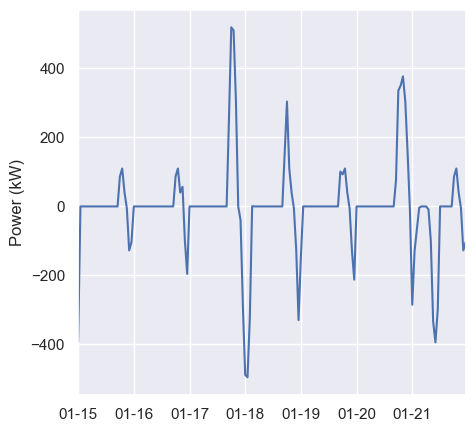

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax.plot(dates[start:end], res_df["battery"][start:end])

# ax.set_title("Battery Power")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)

figs["battery_P"] = fig

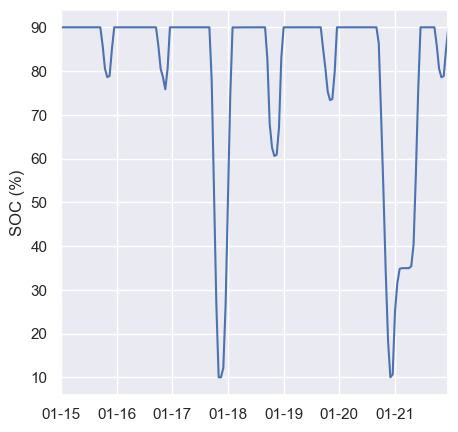

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax.plot(dates[start:end], hybrid_plant.battery.outputs.SOC[start:end])

# ax.set_title("Battery SOC")
ax.set_ylabel("SOC (%)")
ax.set_xmargin(0)

figs["battery_SOC"] = fig

In [23]:
1 - hybrid_plant.grid.missed_load_percentage

0.8506592931076603

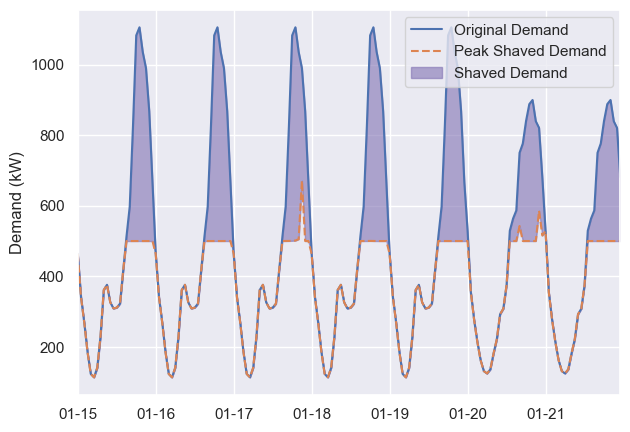

In [24]:
fig, ax = plt.subplots(figsize=(7, 5))

x = np.arange(8760)
y = np.array(hybrid_plant.generation_profile["hybrid"]) / 1000

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax.plot(dates[start:end], res_df["ev_load"][start:end], label="Original Demand")
ax.plot(dates[start:end], res_df["y_peak_shaved"][start:end], linestyle="dashed", label="Peak Shaved Demand")

ax.fill_between(
    dates[start:end],
    res_df["y_peak_shaved"][start:end],
    res_df["ev_load"][start:end],
    label="Shaved Demand",
    color="C4",
    alpha=.6
)
        
ax.set_ylabel("Demand (kW)")
ax.set_xmargin(0)

ax.legend()

figs["peak_shaving_results"] = fig

(array([ 744.,  184.,  143.,  172.,  141.,  162.,  139.,  168.,  152.,
         166.,  165.,  174.,  174.,  168.,  194.,  226.,  203.,  219.,
         211., 4855.]),
 array([10.00000002, 14.00000275, 18.00000548, 22.00000821, 26.00001093,
        30.00001366, 34.00001639, 38.00001911, 42.00002184, 46.00002457,
        50.0000273 , 54.00003002, 58.00003275, 62.00003548, 66.0000382 ,
        70.00004093, 74.00004366, 78.00004639, 82.00004911, 86.00005184,
        90.00005457]),
 <BarContainer object of 20 artists>)

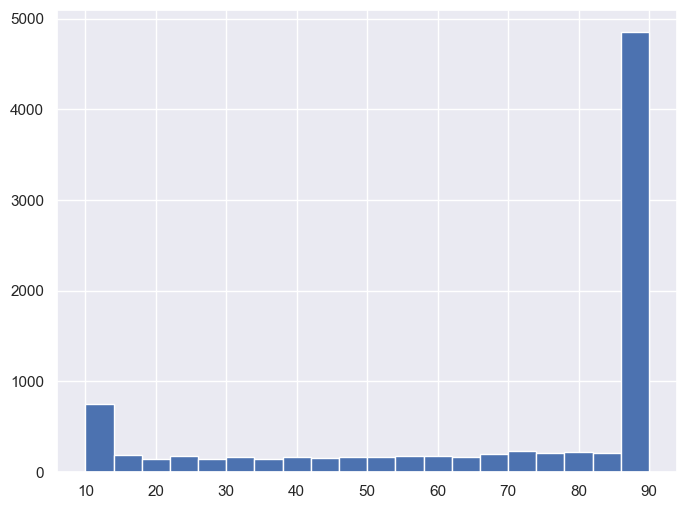

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(hybrid_plant.battery.outputs.SOC, bins=20)

In [34]:
if SAVE_FIGS:
    save_figs(figs)